## Data processing

In [16]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav

%matplotlib inline

PATH = './vowels/'

In [17]:
import enum

def getGenderFromFilename(filename):
    if(filename[2] == 'f'):
        return 1 # female
    elif(filename[2] == 'm'):
        return 0 # male
    else:
        return 2 # kid
    
def getVoiceTypeFromFilename(filename):
    if(filename[0] == 's'):
        return 0 # syntetic voice
    else:
        return 1 # real voice
    
def isAdult(filename):
    return filename[1] != 'k'


In [18]:
from pathlib import Path
from python_speech_features import mfcc

mfccRawDatas = []

#Read all the wav files
pathlist = Path(PATH).glob('*.wav')
for path in pathlist:
    sample_rate, X = wav.read(str(path))
    category = getGenderFromFilename(path.stem)

    voiceType = getVoiceTypeFromFilename(path.stem)
    
    #Append the data as a tuple of : (category (male, female or kid), voicetype (natural or synthetic),Mfcc data)
    mfccRawDatas.append((category, voiceType, mfcc(X, samplerate = sample_rate, nfft = 1024)))


In [19]:
mfccDatas = []
#Recuce the MFCCs datas with a mean of all values
for i in range(len(mfccRawDatas)) :
    #Take the means of all windows
    values = mfccRawDatas[i][2].mean(axis=0)
    #Add the gender
    values = np.append(values, mfccRawDatas[i][0])
    #Add the voicetype
    #values = np.append(values, mfccRawDatas[i][1])
    #Put the row in the array
    mfccDatas.append(values)


In [20]:
#For the rest of the first phase, we'll take only male and female datas.
datas = []

#dataset = np.zeros((len(mfccDatas), len(mfccDatas)))
for d in mfccDatas:
    if(d[-1] != 2):
        datas.append(d)

datas = np.asarray(datas)
#180 x 14

In [6]:
datas.shape

(144, 14)

## Training part

In [8]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv
%matplotlib inline

In [9]:
EPOCHS = 300
LEARNING_RATE = 0.001
MOMENTUM = 0.9

K = 5
N_TESTS = 5
N_NEURONS = [3, 5, 7]

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))


for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13, h , 1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            datas,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2 
        

print("Done !")

Testing 3 neurons...
Testing 5 neurons...
Testing 7 neurons...
Done !


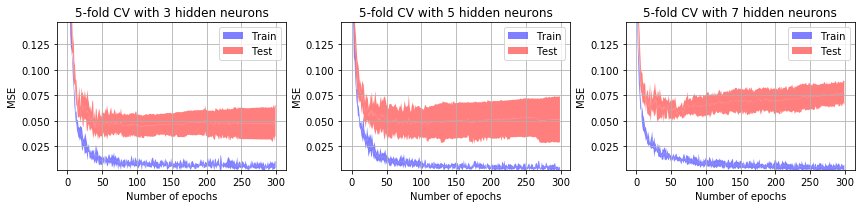

In [10]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

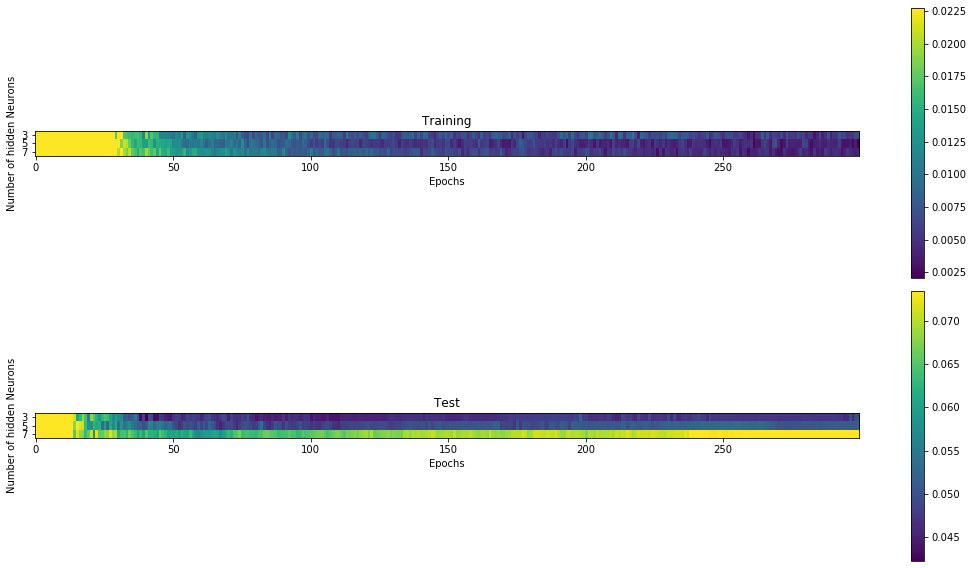

In [26]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

# The final model
An artificial neural network with 3 neurons in the hidden layer and 200 epochs is enough to solve the problem.
With taking the means of the MFCC datas and a learning rate=0.001, momentum=0.9 and a threshold = 0.5

In [12]:
nn = mlp.MLP([13,3,1], 'tanh')

In [13]:
LEARNING_RATE = 0.001
MOMENTUM = 0.9
THRESHOLD = 0.5
EPOCHS = 200

MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          datas,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=EPOCHS,
                                                          threshold=THRESHOLD)

In [14]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.00368064391907766
MSE test:  0.041712973196441364
Confusion matrix:
[[68.  4.]
 [ 3. 69.]]


In [15]:
tp = np.diag(conf_mat)
fp = np.sum(conf_mat, axis=0) - tp
fn = np.sum(conf_mat, axis=1) - tp
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fscore = 2 * recall * precision / (recall + precision)

print("Classes: man - woman")
print("Precision: ", precision)
print("Recall: ", recall)
print("F-score: ", fscore)

Classes: man - woman
Precision:  [0.95774648 0.94520548]
Recall:  [0.94444444 0.95833333]
F-score:  [0.95104895 0.95172414]
